In [50]:
import Bio.SeqIO
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
file="msa.txt"

In [52]:
msa=np.array(list(Bio.SeqIO.parse(file,"fasta"))) #importing msa file

In [53]:
msa.shape

(12702, 100)

In [54]:
def clean_msa(msa): #deleting columns with more than L/2 missing aminoacids
    N=msa.shape[1]
    L=msa.shape[0]
    ind=[]
    for i in range(N):
        counter=0
        for j in range(L):
            if msa[j][i]=='.':
                counter+=1
        if counter < L/2:
            ind.append(i)
    return msa[:,ind]

In [55]:
msa_cleaned=clean_msa(msa)
msa_cleaned.shape

(12702, 46)

In [56]:
def get_marginal(col,am): #calculating marginal probabilities
    ind= col==am
    prob= np.sum(ind)/len(ind)
    return ind,prob

In [57]:
def get_MI(msa): #calculating the mutual information matrix
    n=len(msa[0,:])
    N=len(msa[:,0])
    MI=np.zeros((n,n))
    amino=["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
    for i in range(n):  
        col_i=msa[:,i]
        for j in range(i,n):
            col_j=msa[:,j]
            for a in amino:
                ind_a,p_a=get_marginal(col_i,a)
                for b in amino:
                    ind_b,p_b=get_marginal(col_j,b)
                    p_ab=np.sum(ind_a & ind_b)/N
                    if p_a*p_b!=0 and p_ab!=0: 
                        MI[i,j]+=p_ab*math.log(p_ab/(p_a*p_b),2) 
    return MI

In [58]:
mat=get_MI(msa_cleaned)
mat

array([[0.9542044 , 0.2244511 , 0.13447098, ..., 0.01852179, 0.03378736,
        0.05685731],
       [0.        , 1.72977202, 0.18150665, ..., 0.04192643, 0.04952193,
        0.06869801],
       [0.        , 0.        , 2.87349942, ..., 0.0272659 , 0.04890954,
        0.04626602],
       ...,
       [0.        , 0.        , 0.        , ..., 2.62275209, 0.15144797,
        0.09397022],
       [0.        , 0.        , 0.        , ..., 0.        , 3.35387347,
        0.20553247],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.55371095]])

In [59]:
#mutual information as a symmetric matrix
mi=mat+np.matrix.transpose(mat)-np.diag(np.diag(mat))
mi

array([[0.9542044 , 0.2244511 , 0.13447098, ..., 0.01852179, 0.03378736,
        0.05685731],
       [0.2244511 , 1.72977202, 0.18150665, ..., 0.04192643, 0.04952193,
        0.06869801],
       [0.13447098, 0.18150665, 2.87349942, ..., 0.0272659 , 0.04890954,
        0.04626602],
       ...,
       [0.01852179, 0.04192643, 0.0272659 , ..., 2.62275209, 0.15144797,
        0.09397022],
       [0.03378736, 0.04952193, 0.04890954, ..., 0.15144797, 3.35387347,
        0.20553247],
       [0.05685731, 0.06869801, 0.04626602, ..., 0.09397022, 0.20553247,
        1.55371095]])

In [60]:
def remove_diag(mat): #putting the max value of the matrix onto the diagonal
    for i in range(len(mat)):
        mat[i,i]=0
    for i in range(len(mat)):
        mat[i,i]=mat.max()

In [61]:
remove_diag(mi)
mi

array([[0.40642286, 0.2244511 , 0.13447098, ..., 0.01852179, 0.03378736,
        0.05685731],
       [0.2244511 , 0.40642286, 0.18150665, ..., 0.04192643, 0.04952193,
        0.06869801],
       [0.13447098, 0.18150665, 0.40642286, ..., 0.0272659 , 0.04890954,
        0.04626602],
       ...,
       [0.01852179, 0.04192643, 0.0272659 , ..., 0.40642286, 0.15144797,
        0.09397022],
       [0.03378736, 0.04952193, 0.04890954, ..., 0.15144797, 0.40642286,
        0.20553247],
       [0.05685731, 0.06869801, 0.04626602, ..., 0.09397022, 0.20553247,
        0.40642286]])

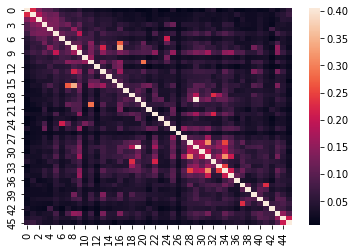

In [62]:
hm = sns.heatmap(mi) #heatmap without any correction
fig = hm.get_figure()
plt.savefig("heatmap1.pdf",format='pdf')

In [63]:
def correct_map(mat): #applying correction
    n=mat.shape[0]
    mi = np.zeros(shape = (n,n))
    for i in range(n):
        for j in range(n):
            s = sum(mat[:,j]+mat[i,:])
            mi[i,j] = mat[i,j] - s / n
    return mi

In [64]:
corrected_mi=correct_map(mi)
corrected_mi

array([[ 0.32354441,  0.12782706,  0.03744785, ..., -0.09763791,
        -0.06895454, -0.02726854],
       [ 0.12782706,  0.29605322,  0.07073793, ..., -0.08797887,
        -0.06696556, -0.02917344],
       [ 0.03744785,  0.07073793,  0.29525505, ..., -0.10303848,
        -0.06797704, -0.05200451],
       ...,
       [-0.09763791, -0.08797887, -0.10303848, ...,  0.25698191,
         0.01542482, -0.02343688],
       [-0.06895454, -0.06696556, -0.06797704, ...,  0.01542482,
         0.28381751,  0.10154317],
       [-0.02726854, -0.02917344, -0.05200451, ..., -0.02343688,
         0.10154317,  0.32104961]])

In [65]:
mi_normalized = (corrected_mi - corrected_mi.min())/(corrected_mi.max() - corrected_mi.min()) #normalizing the matrix
mi_normalized

array([[0.96865785, 0.54882139, 0.35494748, ..., 0.06517283, 0.126702  ,
        0.21612331],
       [0.54882139, 0.90968603, 0.42635856, ..., 0.0858926 , 0.13096859,
        0.21203708],
       [0.35494748, 0.42635856, 0.90797387, ..., 0.05358798, 0.12879885,
        0.16306178],
       ...,
       [0.06517283, 0.0858926 , 0.05358798, ..., 0.82587354, 0.30770552,
        0.22434267],
       [0.126702  , 0.13096859, 0.12879885, ..., 0.30770552, 0.88343903,
        0.49243938],
       [0.21612331, 0.21203708, 0.16306178, ..., 0.22434267, 0.49243938,
        0.9633062 ]])

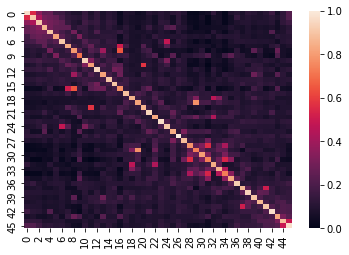

In [66]:
hm2 = sns.heatmap(mi_normalized) #heatmap of the corrected and normalized matrix
fig2 = hm.get_figure()
plt.savefig("heatmap2.pdf",format='pdf')

In [67]:
def get_contact(mat,treshold): #getting the contact map
    cm=np.zeros((len(mat),len(mat)))
    cm[mat>=treshold]=1
    cm[mat<treshold]=0
    return cm


def get_array(cm): #modifying the format for ft-comar
    cm=cm.flatten()
    return np.insert(cm,0,len(mat))

544.0

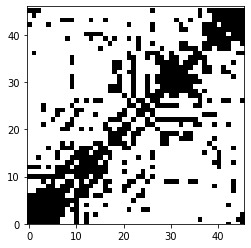

In [68]:
#contact map of MI matrix
cm=get_contact(mi_normalized,0.13)
plt.imshow(cm, cmap='Greys')
plt.ylim(0, 46)
plt.savefig("cm.pdf",format='pdf')

#create array contact map:
array=get_array(cm)
sum(array)-2*array[0] #ones outside from the diagonal

# After using FT-COMAR and Pymol

In [71]:
# saving contact maps for different tresholds in range [0.1,0.3)

treshold=0.1

for i in range(20):
    cm=get_contact(mi_normalized,treshold)
    array=get_array(cm)
    with open(f'ft-comar/cm_{i}.lst','w') as f:
        for s in array:
            lines=f.write(str(int(s)) + '\n')
    treshold+=0.01

In [72]:
rmsd=[6.216523,5.757605,6.448245,5.045444,8.849254,5.592339,5.291924,8.890546,5.619896,7.869664,
      5.995107,7.106183,8.838693,7.728411,6.787165 ,9.036237,5.711966,8.256195,9.197262,8.395659]
tr=np.arange(0.1,0.3,0.01)
rmsd_min=min(rmsd)
tr_min=tr[np.argmin(rmsd)]

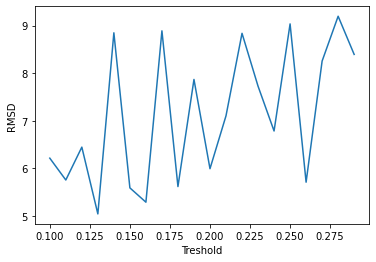

In [73]:
plt.plot(tr,rmsd)
plt.xlabel('Treshold')
plt.ylabel('RMSD')
plt.savefig("rmsd.pdf",format='pdf')

In [74]:
print(tr_min,rmsd_min)

0.13 5.045444
